# Handling Missing Values in Python

![](https://imgur.com/68u0dD2.png)

>Real world data is messy and often contains a lot of missing values. There could be multiple  reasons for the missing values but primarily the reason for missingness can be attributed to 

| Reason for missing Data |  
|--|
|Data doesn't exist  |  
|Data not collected due to human error.  |  
|Data deleted accidently  |  
|                         |

 Either way we need to address this issue before we  proceed with the modeling stuff. It is also important to note that some algorithms like `XGBoost` and `LightGBM` can treat missing data without any preprocessing.
<hr>


# Objective
The objective of this notebook is to detect missing values and then go over some of the methods used for imputing them.
<hr>


# Data

There are two publically available datasets which will be used to explain the concepts:

* 1. Titanic Dataset for Non Time Series problem
* 2. Air Quality of India 2005 to 2020 for Time Series problem


# Loading necessary libraries and datasets

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno



Ref : MissingNo Library 
https://github.com/ResidentMario/missingno 

## Reading in the dataset
* Reading in the Titanic Dataset.

In [4]:
train=pd.read_csv('D:\\G_Drive_Jan2020\\DV Analytics\\ML Class\\Titanic\\train.csv')
test=pd.read_csv('D:\\G_Drive_Jan2020\\DV Analytics\\ML Class\\Titanic\\test.csv')

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

# First few rows of the training dataset
train.head()


Training data shape:  (891, 12)
Testing data shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examining the Target column 

>For each passenger in the test set, we need to create a model that predicts whether or not the passengers survived the sinking of the Titanic. Hence Survived is that target column in the dataset. Let's examine the Distribution of the target column

In [6]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

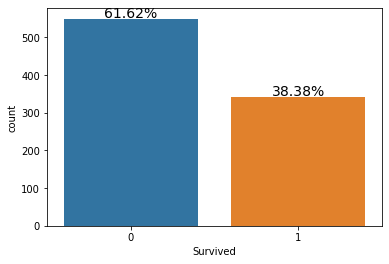

In [7]:
s = sns.countplot(x = 'Survived',data = train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

Here:
* 0: Did not Survive while 
* 1: Survived. 

Clearly, less people survived the accident.

>Since the focus of the notebook is to detect and handle missing values, we'll jump directly into it. Let's now look at a step by step process to manage the missing values in a dataset.
<hr>

# Detecting Missing values

## Detecting missing values numerically 

>The first step is to detect the count/percentage of missing values in every column of the dataset. This will give an idea about the distribution of missing values.

In [8]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns



In [13]:
mis_val = train.isnull().sum()
mis_val

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train_missing= missing_values_table(train)
train_missing

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [10]:
test_missing= missing_values_table(test)
test_missing

Your selected dataframe has 11 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


Both the train and test set have the same proportion of the missing values. 

## Detecting missing data visually using Missingno library

>To graphically analyse the missingness of the data, let's use a library called [Missingno](https://github.com/ResidentMario/missingno) It is a package for graphical analysis of missing values. To use this library, we need to import it as follows: `import missingno as msno`

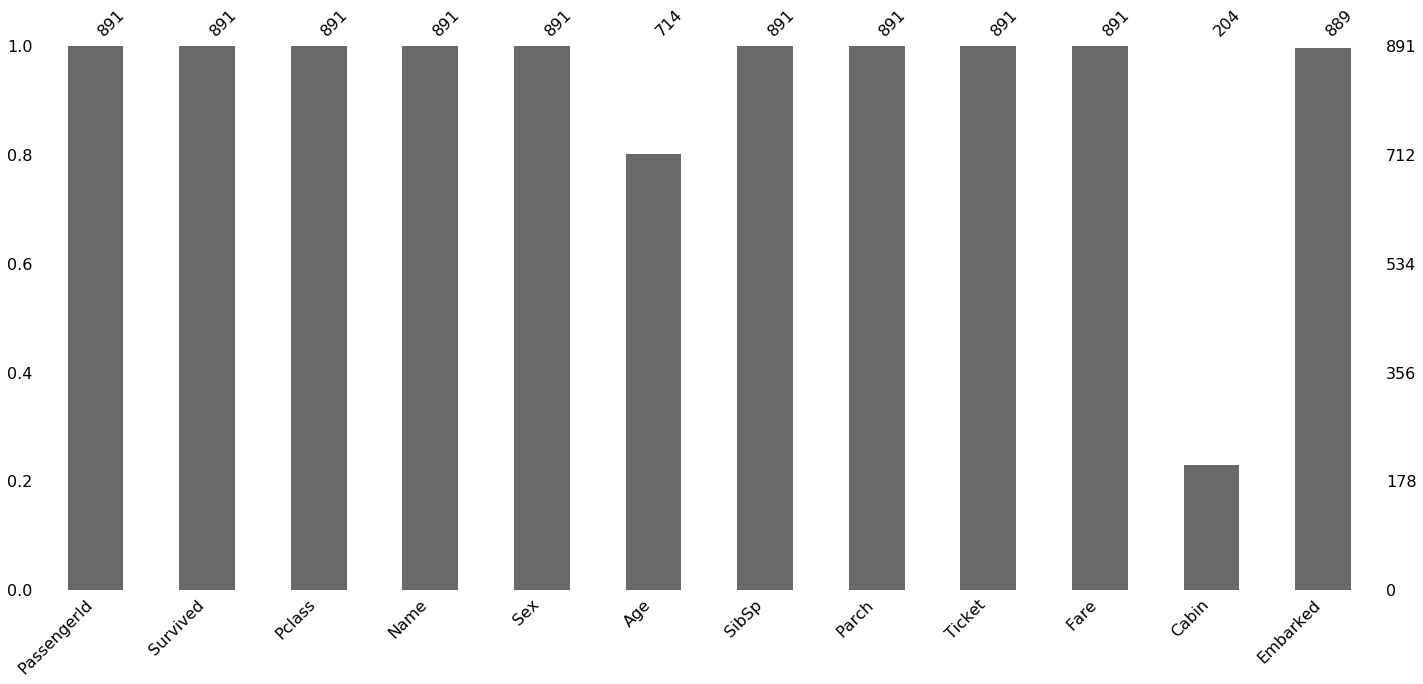

In [14]:
msno.bar(train)

>The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that Age, Cabin and embarked columns have missing values. Next,it would make sense to find out the locations of the missing data.

### Visualizing the locations of the missing data 

>The [msno.matrix](https://github.com/ResidentMario/missingno#matrix) nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.


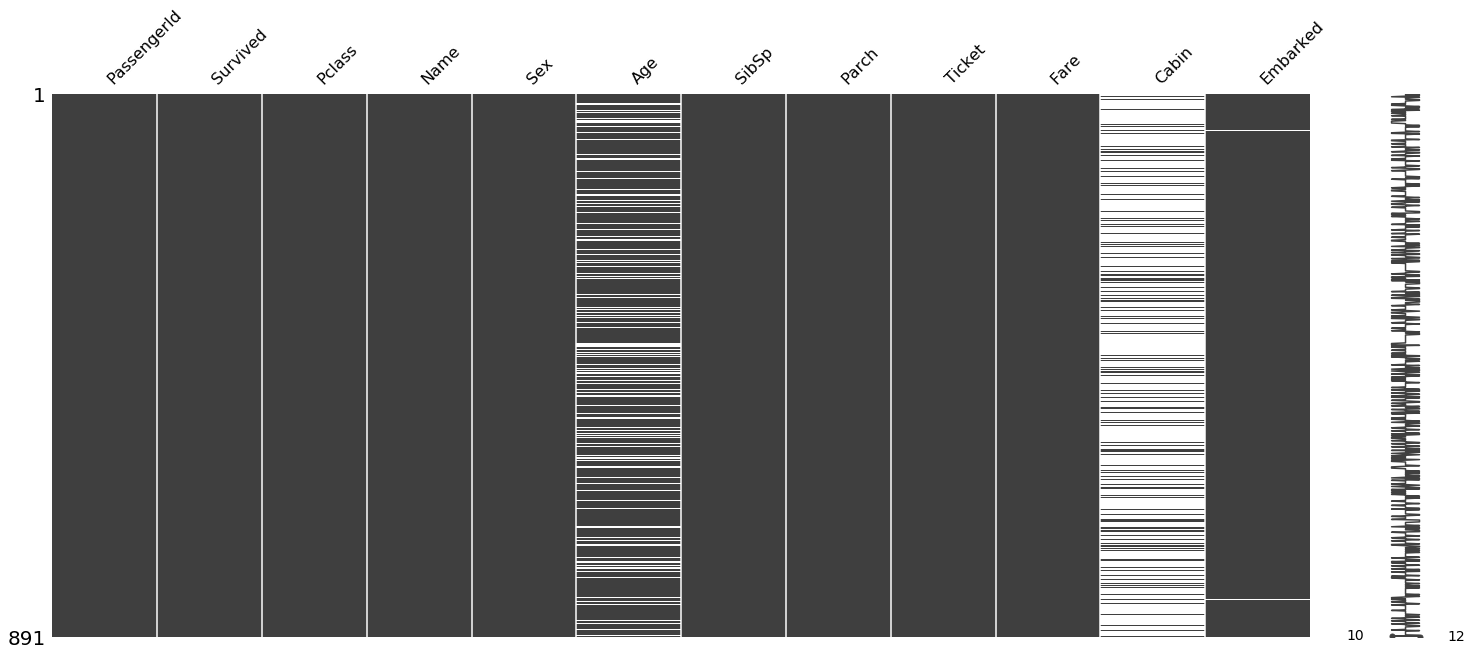

In [15]:
msno.matrix(train)

>* The plot appears blank(white) wherever there are missing values. For instance, in Embarked column there are only two instances of missing data, hence the two white lines.
>
>* The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.
>
>It is also possible to sample the dataset to pinpoint the exact location of the missing values. For instance let's check the first 100 rows.

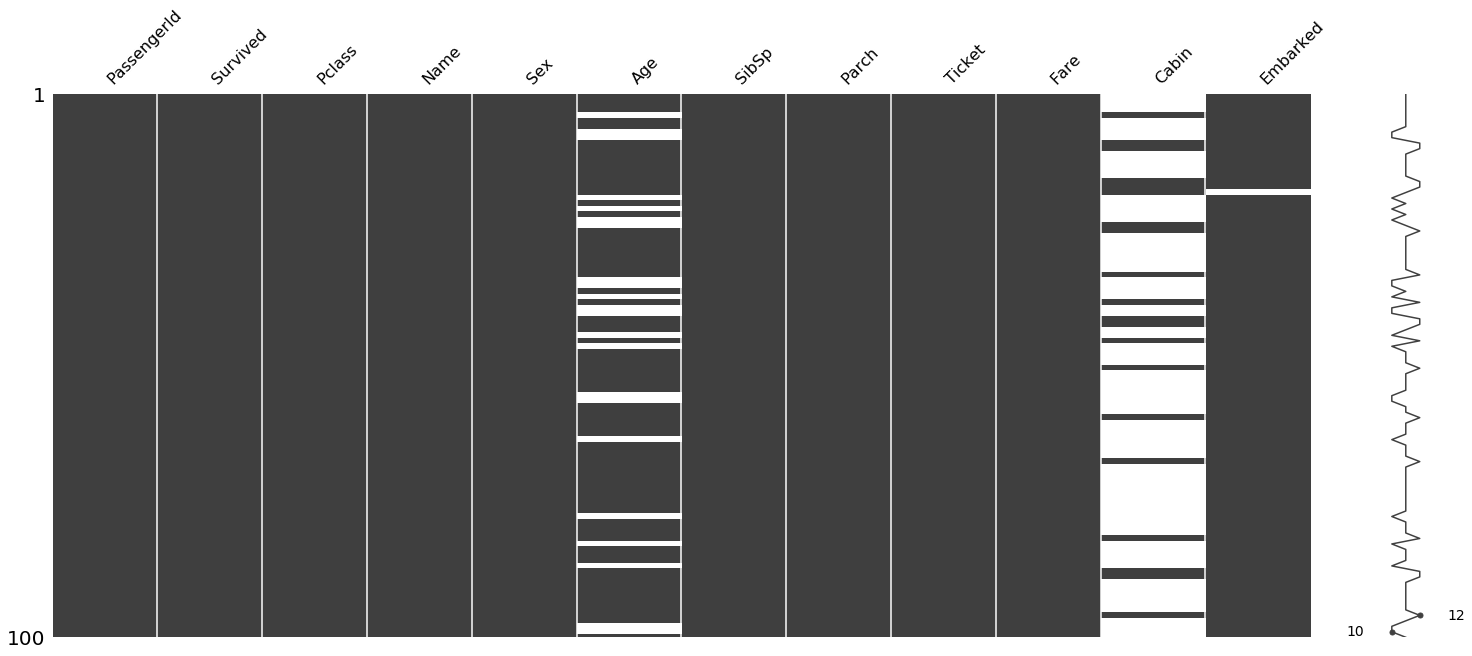

In [16]:
msno.matrix(train.sample(100))

This shows that the Embarked column has no nullity in the first 100 cases.

# Reasons for Missing Values 

>Before we start treating the missing values ,it is important to understand the various reasons for the missingness in data. Broadly speaking, there can be three possible reasons:

![](https://cjasn.asnjournals.org/content/clinjasn/early/2014/02/06/CJN.10141013/F2.large.jpg?width=800&height=600&carousel=1)

source:https://cjasn.asnjournals.org/content/early/2014/02/06/CJN.10141013/tab-figures-data?versioned=true


**1. Missing Completely at Random (MCAR) **

>The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

**2. Missing at Random (MAR) **

>MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

**3. Missing Not at Random (MNAR) **
>Missingness depends on unobserved data or the value of the missing data itself. 

*All definitions taken from Wikipedia: https://en.wikipedia.org/wiki/Missing_data*


>Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.


## Finding reason for missing data using matrix plot 

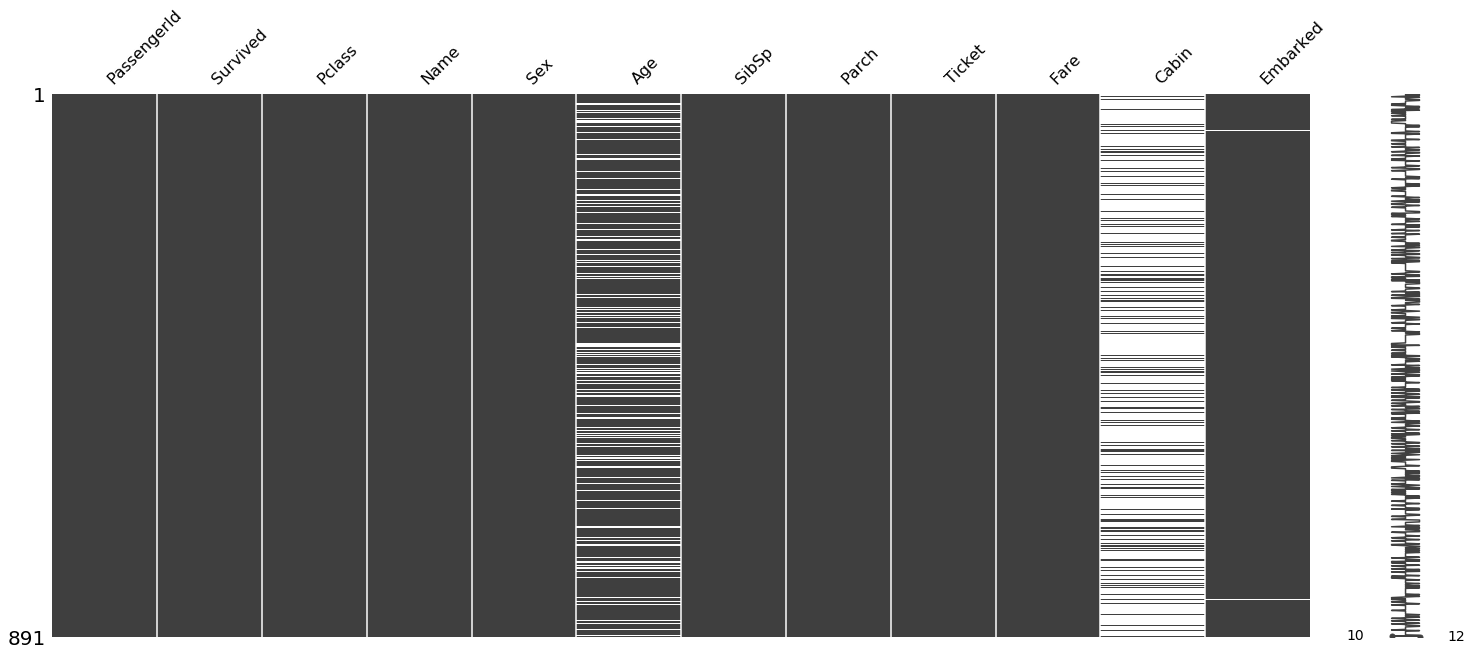

In [17]:
msno.matrix(train)

>* The `Embarked` Column has very few missing values and donot seem to be correlated with any other column, Hence, the missingness in Embarked column can be attributed as Missing Completely at Random.
* Both the `Age` and the `Cabin` columns have a lot of missing values.This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

The missingno package also let's us sort the graph by a particluar column. Let's sort the values by `Age` and `Cabin` column to see if there is a pattern in the missing values

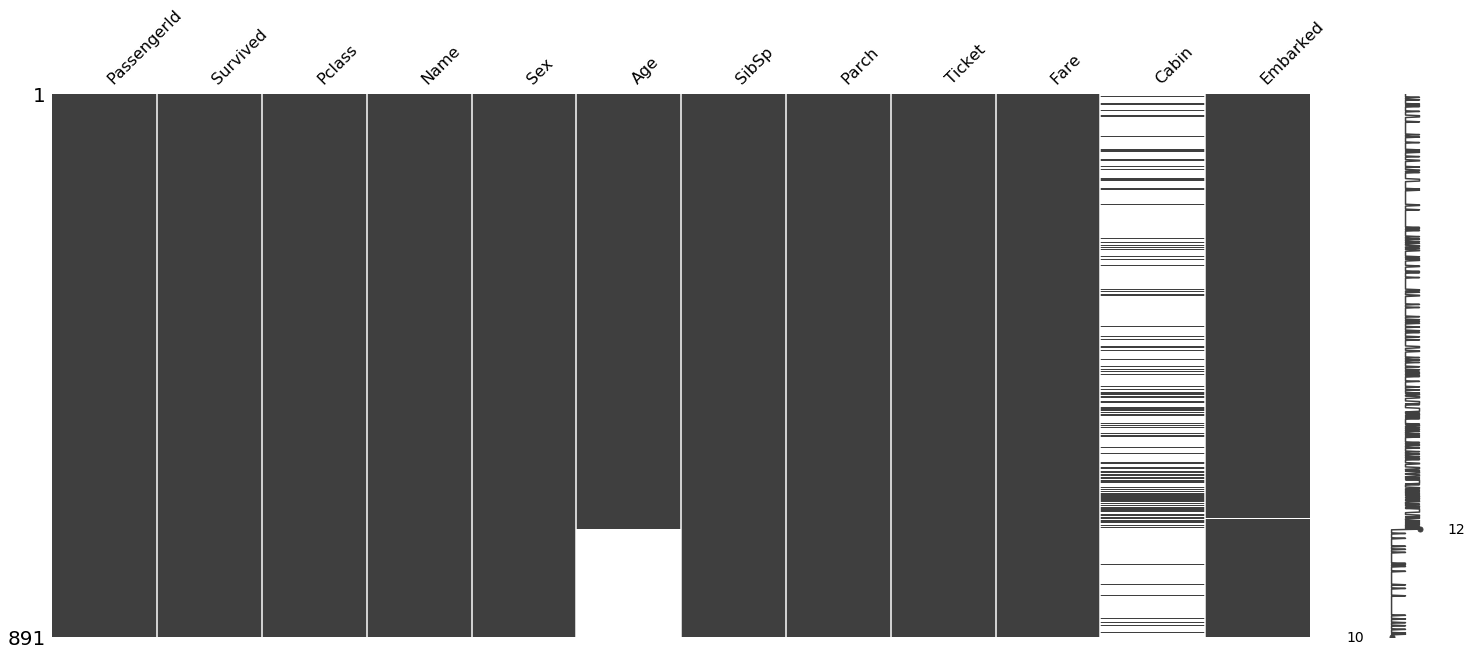

In [18]:
#sorted by Age
sorted = train.sort_values('Age')
msno.matrix(sorted)

Hence it is clear that here is no relation between the missingness in Age and Cabin column.To cement this conclusion further we can also draw a Heatmap among the different variables in the dataset.

## Finding reason for missing data using a Heatmap 

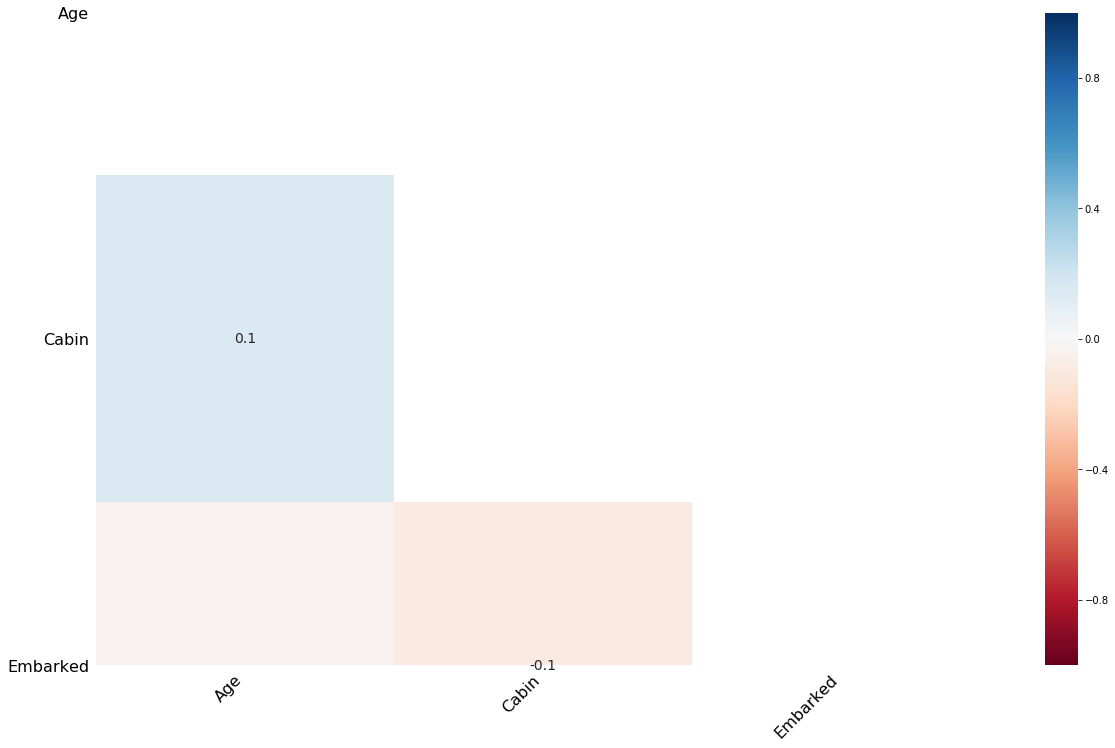

In [19]:
msno.heatmap(train)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

## Finding reason for missing data using Dendrogram 
A dendogram is a tree diagram of missingness. It groups the highly correlated variables together.

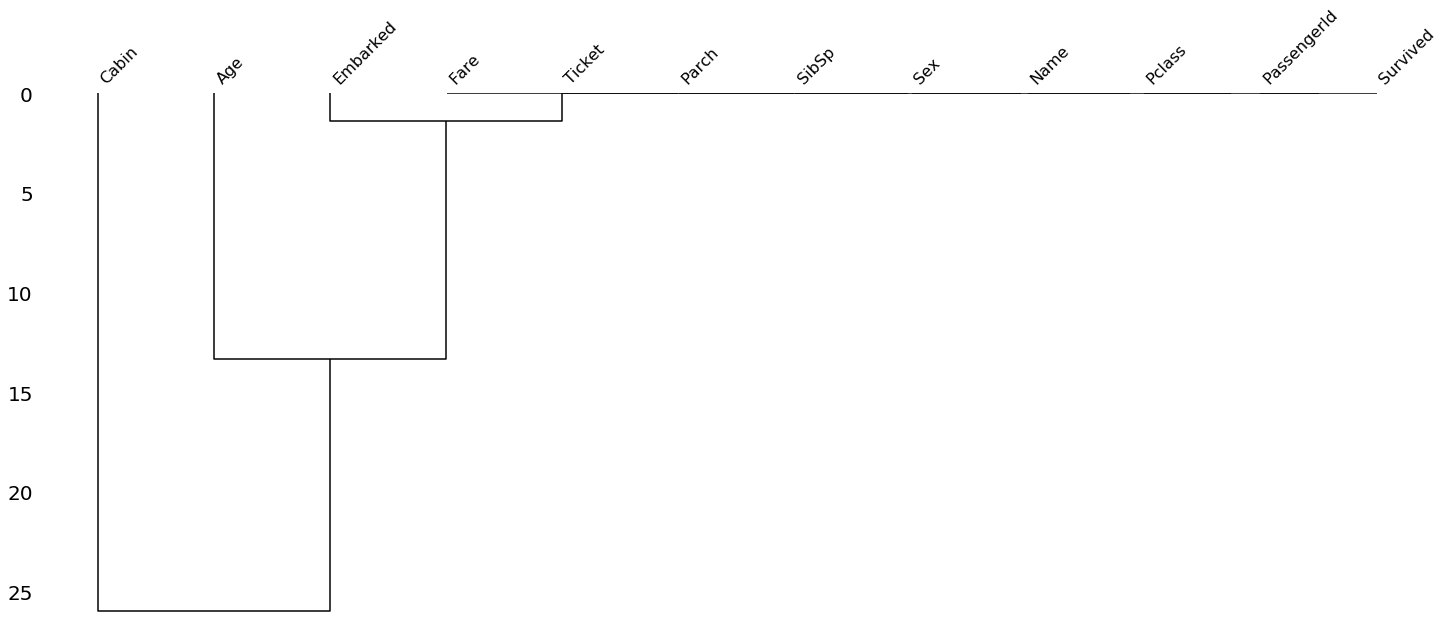

In [20]:
msno.dendrogram(train)

>Let's read the above dendrogram from a top-down perspective: 
* Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on(missingno documentation)
>
>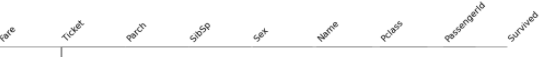
>
>* the missingness of Embarked tends to be more similar to Age than to Cabin and so on.However, in this particluar case, the correlation is high since Embarked column has a very few missing values.

This dataset doesn't have much missing values but if you use the same methodology on datasets having a lot of missing values, some interesting pattern will definitely emerge.

# Treating Missing values  

After having identified the patterns in missing values, it is important to treat them too. Here is a flowchart which could prove handy:



## Deletions 

![](https://imgur.com/tBvdfyX.png)

>Deletion means to delete the missing values from a dataset. This is however not recommended as it might result in loss of information from the dataset. We should only delete the missing values from a dataset if their proportion is very small. Deletions are further of three types: 

### Pairwise Deletion 

Parwise Deletion is used when values are missing completely at random i.e MCAR. During Pairwise deletion, only the missing values are deleted. All operations in pandas like mean,sum etc intrinsically skip missing values.




In [21]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [22]:
train_1 = train.copy()
train_1['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.69911764705882


### Listwise Deletion/ Dropping rows

>During Listwise deletion, complete rows(which contain the missing values) are deleted. As a result, it is also called Complete Case deletion. Like Pairwise deletion, listwise deletions are also only used for MCAR values.


In [23]:
#Drop rows which contains any NaN or missing value for Age column
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

0

In [25]:
train_1['Age'].mean()

29.69911764705882

In [26]:
train_1.shape

(714, 12)

>The Age column doesn't have any missing values.A major disadvantage of Listwise deletion is that a major chunk of data and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.


### Dropping complete columns 

If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. However, again, it is not a good methodology to delete data.


## Imputations Techniques for non Time Series Problems 

![](https://imgur.com/bL0iHde.png)

>Imputation refers to replacing missing data with substituted values.There are a lot of ways in which the missing values can be imputed depending upon the nature of the problem and data. Dependng upon the nature of the problem, imputation techniques can be broadly they can be classified as follows:


### Basic Imputation Techniques
  
  - Imputating with a constant value
  - Imputation using the statistics (mean, median or most frequent) of each column in which the missing values are located

For this we shall use the `The SimpleImputer` class from sklearn.

In [51]:
# imputing with a constant

from sklearn.impute import SimpleImputer
train_constant = train.copy()
#setting strategy to 'constant' 


In [52]:
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value

In [53]:
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)

In [54]:
train_constant.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [56]:
train_constant['Age'] = pd.to_numeric(train_constant['Age'] , errors= 'coerce')

In [57]:
train_constant.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [67]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [68]:
train_most_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [60]:
train_most_frequent.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Imputations Techniques for Time Series Problems

Now let's look at ways to impute data in a typical time series problem. Tackling missing values in time Series problem is a bit different. The `fillna()` method is used for imputing missing values in such problems.

* Basic Imputation Techniques
  - 'ffill' or 'pad' - Replace NaN s with last observed value
  - 'bfill' or 'backfill' - Replace NaN s with next observed value
  -  Linear interpolation method

### Time Series dataset

The dataset is called Air Quality of India and it contains air quality data and AQI (Air Quality Index) at hourly and daily level of various stations across multiple cities in India.The dataset has a lot of missing values and and is a classic Time series problem.

In [69]:
city_day = pd.read_csv('D:\\G_Drive_Jan2020\\DV Analytics\\ML Class\\Air Quality India\\city_day.csv',parse_dates=True,index_col='Date')
city_day1=city_day.copy(deep=True)
city_day.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [71]:
city_day.shape

(26219, 15)

In [70]:
#Missing Values
city_day_missing= missing_values_table(city_day)
city_day_missing

Your selected dataframe has 15 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,16807,64.1
PM10,10766,41.1
NH3,9847,37.6
Toluene,7555,28.8
Benzene,5287,20.2
PM2.5,4289,16.4
AQI,4282,16.3
AQI_Bucket,4282,16.3
NOx,4043,15.4
O3,3660,14.0


There are a lot of missing values and some of the columns like Xylene and PM10 have more than 50% of the values missing. Let's now see how we can impute these missing values.



In [72]:
# Imputation using ffill/pad
# Imputing Xylene value

city_day['Xylene'][50:64]


Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
Name: Xylene, dtype: float64

Above we see, there are 3 missing values in the Xylene column. 

### Imputing using ffill

In [76]:
city_day.fillna(method='ffill',inplace=True)
#city_day.isnull().sum()

In [75]:
city_day['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26     0.81
2015-02-27     0.81
2015-02-28     0.81
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06     4.13
Name: Xylene, dtype: float64

We can see that all missing values have been filled with the last observed values.

### Imputation using bfill

In [77]:
# Imputing AQI value

city_day['AQI'][20:30]

Date
2015-01-21      NaN
2015-01-22      NaN
2015-01-23      NaN
2015-01-24      NaN
2015-01-25      NaN
2015-01-26      NaN
2015-01-27      NaN
2015-01-28      NaN
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

In [78]:
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

Date
2015-01-21    209.0
2015-01-22    209.0
2015-01-23    209.0
2015-01-24    209.0
2015-01-25    209.0
2015-01-26    209.0
2015-01-27    209.0
2015-01-28    209.0
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

We can see that all missing values have been filled with the next observed values.

### Imputation using Linear Interpolation method

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the best possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

[Linear interpolation](https://www.lexjansen.com/nesug/nesug01/ps/ps8026.pdf) is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point. 

Refer to the official documentation for a complete list of interpolation strategies [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In [ ]:
city_day1['Xylene'][50:65]

In [ ]:
# Interpolate using the linear method
city_day1.interpolate(limit_direction="both",inplace=True)
city_day1['Xylene'][50:65]

## Advanced Imputation Techniques 

Advanced imputation techniques uses machine learning algorithms to impute the missing values in a dataset unlike the previous techniques where we used other column values to predict the missing values. We shall look at the following two techniques in this notebook:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
* [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

### K-Nearest Neighbor Imputation

The [KNNImputer class](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) provides imputation for filling in missing values using the k-Nearest Neighbors approach.Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. 

In [12]:
train_knn = train.copy(deep=True)

In [6]:
from sklearn.impute import KNNImputer
train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [7]:
train_knn['Age'].isnull().sum()


0

In [8]:
train_knn['Age'].isnull().sum()

0

### Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:



In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

mice_imputer = IterativeImputer()
train_mice['Age'] = mice_imputer.fit_transform(train_mice[['Age']])

In [10]:
train_mice['Age'].isnull().sum()

0

# Algorithms which handle missing values

Some algprithms like XGBoost and LightGBM can handle missing values without any preprocessing, by supplying relevant parameters.

* [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
![](https://imgur.com/GNlcWoJ.png)

* [LightGBm](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html)
![](https://imgur.com/GVdcx7h.png)


# Conclusion

Well, there is single best way to handle missing values. One needs to experiment with different methods and then decide which method is best for a particular problem.

In [13]:
%pwd

'D:\\G_Drive_Jan2020\\Python'